In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp "/content/drive/MyDrive/tennis_court_det_dataset.zip" "/content/"

In [3]:
!unzip tennis_court_det_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/images/JNKp7sCdQlY_2200.png  
  inflating: data/images/JNKp7sCdQlY_2250.png  
  inflating: data/images/JNKp7sCdQlY_250.png  
  inflating: data/images/JNKp7sCdQlY_300.png  
  inflating: data/images/JNKp7sCdQlY_350.png  
  inflating: data/images/JNKp7sCdQlY_400.png  
  inflating: data/images/JNKp7sCdQlY_450.png  
  inflating: data/images/JNKp7sCdQlY_50.png  
  inflating: data/images/JNKp7sCdQlY_500.png  
  inflating: data/images/JNKp7sCdQlY_550.png  
  inflating: data/images/JNKp7sCdQlY_600.png  
  inflating: data/images/JNKp7sCdQlY_650.png  
  inflating: data/images/JNKp7sCdQlY_700.png  
  inflating: data/images/JNKp7sCdQlY_750.png  
  inflating: data/images/juXbdW7z0WA_100.png  
  inflating: data/images/juXbdW7z0WA_1050.png  
  inflating: data/images/juXbdW7z0WA_1100.png  
  inflating: data/images/juXbdW7z0WA_200.png  
  inflating: data/images/juXbdW7z0WA_350.png  
  inflating: data/images/juXbdW7z0WA_400.png  
  infl

# Start code

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

import json
import cv2
import numpy as np

In [5]:
device_type = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_type

device(type='cuda')

# Create Torch Dataset

In [6]:
class KeypointsDataset(Dataset):
    def __init__(self, img_dir, data_file):
        self.img_dir = img_dir
        with open(data_file, "r") as f:
            self.data = json.load(f)

        self.transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        img = cv2.imread(f"{self.img_dir}/{item['id']}.png")
        h,w = img.shape[:2]

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transforms(img)
        kps = np.array(item['kps']).flatten()
        kps = kps.astype(np.float32)

        kps[::2] *= 224.0 / w # Adjust x coordinates
        kps[1::2] *= 224.0 / h # Adjust y coordinates

        return img, kps

In [7]:
train_dataset = KeypointsDataset("data/images","data/data_train.json")
val_dataset = KeypointsDataset("data/images","data/data_val.json")

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

# Create model

In [8]:
model = models.resnet50(pretrained=True)
model.fc =  torch.nn.Linear(model.fc.in_features, 14*2) # Replaces the last layer

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 90.1MB/s]


In [9]:
model = model.to(device_type)

# Train model

In [10]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [11]:
epochs=15
losses = []

for epoch in range(epochs):
    epoch_loss = 0
    for i, (imgs,kps) in enumerate(train_loader):
        imgs = imgs.to(device_type)
        kps = kps.to(device_type)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, kps)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if i % 10 == 0:
            print(f"Epoch {epoch}/{epochs}, Step {i}/{len(train_loader)}, loss: {loss.item()}")

    epoch_loss /= len(train_loader)
    losses.append(epoch_loss)
    print(f"Epoch {epoch}, average loss: {epoch_loss}")

Epoch 0/15, Step 0/829, loss: 14673.1064453125
Epoch 0/15, Step 10/829, loss: 14185.6884765625
Epoch 0/15, Step 20/829, loss: 14117.009765625
Epoch 0/15, Step 30/829, loss: 13655.7060546875
Epoch 0/15, Step 40/829, loss: 12273.185546875
Epoch 0/15, Step 50/829, loss: 13075.5341796875
Epoch 0/15, Step 60/829, loss: 13295.8349609375
Epoch 0/15, Step 70/829, loss: 11651.1748046875
Epoch 0/15, Step 80/829, loss: 11852.7470703125
Epoch 0/15, Step 90/829, loss: 11661.0986328125
Epoch 0/15, Step 100/829, loss: 11020.5126953125
Epoch 0/15, Step 110/829, loss: 10958.853515625
Epoch 0/15, Step 120/829, loss: 10430.4140625
Epoch 0/15, Step 130/829, loss: 10329.7880859375
Epoch 0/15, Step 140/829, loss: 9363.81640625
Epoch 0/15, Step 150/829, loss: 9179.396484375
Epoch 0/15, Step 160/829, loss: 8926.123046875
Epoch 0/15, Step 170/829, loss: 8586.8388671875
Epoch 0/15, Step 180/829, loss: 8665.8271484375
Epoch 0/15, Step 190/829, loss: 8292.0556640625
Epoch 0/15, Step 200/829, loss: 7769.48828125
E

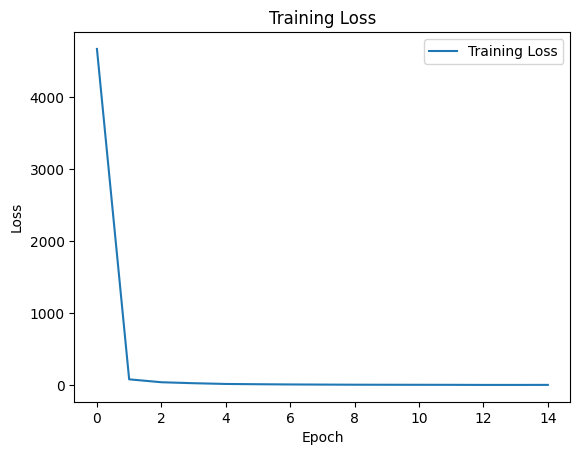

In [12]:
import matplotlib.pyplot as plt

plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [14]:
torch.save(model.state_dict(), "key_points_model.pth")

In [16]:
!cp "keypoints_model.pth" "/content/drive/MyDrive/key_points_model.pth"